# QuickTorch Playground

[Some important Pytorch tasks - A concise summary from a vision researcher](https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/)

[Pytorch common code collection](https://mp.weixin.qq.com/s/CKbIcb-iIKKNVgh2UApmIg)

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [33]:
import matplotlib.pyplot as plt

# Common Code Blocks

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
print(torch.__version__)               # PyTorch version

if torch.cuda.is_available():
    print(torch.version.cuda)              # Corresponding CUDA version
    print(torch.backends.cudnn.version())  # Corresponding cuDNN version
    print(torch.cuda.get_device_name(0))   # GPU type

1.8.0


In [ ]:
# reproduce
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# single card
device = torch.device('cuda'if torch.cuda.is_available() else'cpu')

# multiple cards
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [ ]:
# clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Tensor related

In [2]:
tensor = torch.randn(3,4,5)

print(tensor.type())
print(tensor.size())
print(tensor.dim())

torch.FloatTensor
torch.Size([3, 4, 5])
3


In [ ]:
# old fashion
# Tensor[N, C, H, W]
images = torch.randn(32, 3, 56, 56)
images.sum(dim=1)
images.select(dim=1, index=0)

In [ ]:
# new way
NCHW = ['N', 'C', 'H', 'W']
images = torch.randn(32, 3, 56, 56, names=NCHW)
images.sum('C')
images.select('C', index=0)

# new way 2
tensor = torch.rand(3,4,1,2,names=('C', 'N', 'H', 'W'))

# use align_to to quick reshape
tensor = tensor.align_to('N', 'C', 'H', 'W')

## Transform

In [ ]:
# in pytorch FloatTensor is way faster than DoubleTensor
torch.set_default_tensor_type(torch.FloatTensor)

tensor = tensor.cuda()
tensor = tensor.cpu()
tensor = tensor.float()
tensor = tensor.long()

ndarray = tensor.cpu().numpy()
tensor = torch.from_numpy(ndarray).float

# If ndarray has negative stride
# x = np.random.random(size=(32,32,7))
# torch.from_numpy(np.flip(x, axis=0))
# it's like something contiguous in tensor. the data is stored orderly.
# something like image = image[..., ::-1]
# another way to fix: image = image[..., ::-1] - np.zeros_like(image)
tensor = torch.from_numpy(ndarray.copy()).float()

In [ ]:
# torch and PIL.Image

# pytorch中的张量默认采用[N, C, H, W]的顺序
# 并且数据范围在[0,1], 需要进行转置和规范化

# torch.Tensor -> PIL.Image
image = PIL.Image.fromarray(
    torch.clamp(
        tensor*255, min=0, max=255).byte().permute(1,2,0).cpu().numpy())
image = torchvision.transforms.functional.to_pil_image(tensor)  # Equivalently way

# PIL.Image -> torch.Tensor
path = r'./figure.jpg'
tensor = torch.from_numpy(
    np.asarray(PIL.Image.open(path))).permute(2,0,1).float() / 255
tensor = torchvision.transforms.functional.to_tensor(PIL.Image.open(path)) # Equivalently way

In [ ]:
# numpy and PIL.Image

image = PIL.Image.fromarray(ndarray.astype(np.uint8))

ndarray = np.asarray(PIL.Image.open(path))

In [ ]:
# 从只包含一个元素的张量中提取值

value = torch.rand(1).item()

## re-shape, multiplication etc.

In [ ]:
# 在将卷积层输入全连接层的情况下通常需要对张量做形变处理
# 相比torch.view, torch.reshape可以自动处理输入张量不连续的情况
tensor = torch.rand(2, 3, 4)
shape = (6, 4)
tensor = torch.reshape(tensor, shape)


# 打乱顺序
tensor = tensor[torch.randperm(tensor.size(0))]  # 打乱第一个维度


# 水平翻转
# pytorch不支持tensor[::-1]这样的负步长操作，水平翻转可以通过张量索引实现
# 假设张量的维度为[N, D, H, W].
tensor = tensor[:,:,:,torch.arange(tensor.size(3) - 1, -1, -1).long()]


# 复制张量
# Operation                |  New/Shared memory | Still in computation graph |
tensor.clone()           # |        New         |          Yes               |
tensor.detach()          # |      Shared        |          No                |
tensor.detach.clone()()  # |        New         |          No                |

# 张量拼接
# torch.cat和torch.stack的区别在于
# - torch.cat沿着给定的维度拼接
# - torch.stack会新增一维
# 例如当参数是3个10x5的张量
# - torch.cat的结果是30x5的张量
# - torch.stack的结果是3x10x5的张量

tensor = torch.cat(list_of_tensors, dim=0)
tensor = torch.stack(list_of_tensors, dim=0)

In [ ]:
# 将整数标签转为one-hot编码
# pytorch的标记默认从0开始
tensor = torch.tensor([0, 2, 1, 3])
N = tensor.size(0)
num_classes = 4
one_hot = torch.zeros(N, num_classes).long()
one_hot.scatter_(dim=1, 
                 index=torch.unsqueeze(tensor, dim=1), 
                 src=torch.ones(N, num_classes).long())


# 得到非零元素
torch.nonzero(tensor)               # index of non-zero elements
torch.nonzero(tensor==0)            # index of zero elements
torch.nonzero(tensor).size(0)       # number of non-zero elements
torch.nonzero(tensor == 0).size(0)  # number of zero elements


# 判断两个张量相等
torch.allclose(tensor1, tensor2)  # float tensor
torch.equal(tensor1, tensor2)     # int tensor


# 张量扩展
# Expand tensor of shape 64*512 to shape 64*512*7*7.
tensor = torch.rand(64,512)
torch.reshape(tensor, (64, 512, 1, 1)).expand(64, 512, 7, 7)


# 矩阵乘法
# Matrix multiplcation: (m*n) * (n*p) * -> (m*p).
result = torch.mm(tensor1, tensor2)

# Batch matrix multiplication: (b*m*n) * (b*n*p) -> (b*m*p)
result = torch.bmm(tensor1, tensor2)

# Element-wise multiplication.
result = tensor1 * tensor2


# 计算两组数据之间的两两欧式距离
# 利用broadcast机制
dist = torch.sqrt(torch.sum((X1[:,None,:] - X2) ** 2, dim=2))

# Basics

## New tensor

In [5]:
out_t = torch.tensor([1])
t = torch.ones((3, 3), out=out_t)

print(out_t, '\n', t)
print(id(t) == id(out_t))

t = torch.zeros_like(out_t)

print(out_t, '\n', t)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]) 
 tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])
True
tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]) 
 tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


In [7]:
t = torch.full((3, 3), 10)
print(t)

tensor([[10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]])

In [8]:
# also check torch.logspace
t1 = torch.arange(2, 10, 3)  # 3 is step
t2 = torch.linspace(2, 10, 6)  # 6 is len
print(t1, t2)

tensor([2, 5, 8]) tensor([ 2.0000,  3.6000,  5.2000,  6.8000,  8.4000, 10.0000])


In [10]:
t = torch.eye(3, 4)
print(t)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])


## New tensor: Distribution

In [11]:
# also check torch.rand

# [1] What is produced at this time is a distribution,
# from which the corresponding number of species is sampled
# So this must specify the size, which is how many to extract
t_normal = torch.normal(0, 1, size=(4, ))
print(t_normal)

# [2] At this time, according to the shape and size of the variance, the same multiple distributions will be generated,
# and the mean of each distribution is that scalar
std = torch.arange(1, 5, dtype=torch.float)
print(std.dtype)
t_normal2 = torch.normal(1, std)
print(t_normal2)  # Equal distribution means

# [3] At this time, according to the shape and size of the mean, the same multiple distributions with the same variance will be generated,
# and one value from these distributions will be taken as the result.
mean = torch.arange(1, 5, dtype=torch.float)
t_normal3 = torch.normal(mean, 1)
print(t_normal3)  # Equal distribution variances

# [4] At this time, the number of mean values and the number of variances need to be as many,
# so that so many normal distributions are generated respectively, and a value is extracted from it
mean = torch.arange(1, 5, dtype=torch.float)
std = torch.arange(1, 5, dtype=torch.float)
t_normal4 = torch.normal(mean, std)
print(t_normal4)

tensor([-1.5862,  0.1699, -0.4199,  0.6070])
torch.float32
tensor([-0.3260,  2.0730,  0.1900,  6.0510])
tensor([-0.5818,  2.8980,  4.6313,  5.4605])
tensor([-0.3469,  1.2486,  6.1148,  2.1285])


## Operations

In [12]:
# Only floating-point number type splicing is possible, long type splicing will report an error

t = torch.ones((2, 3))
print(t)

t_0 = torch.cat([t, t], dim=0)  # row
t_1 = torch.cat([t, t], dim=1)  # col
print(t_0, t_0.shape)
print(t_1, t_1.shape)

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]) torch.Size([4, 3])
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]]) torch.Size([2, 6])


In [13]:
t_stack = torch.stack([t, t, t], dim=0)
print(t_stack)
print(t_stack.shape)

t_stack1 = torch.stack([t, t, t], dim=1)
print(t_stack1)
print(t_stack1.shape)

tensor([[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]])
torch.Size([3, 2, 3])
tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
torch.Size([2, 3, 3])


In [15]:
t = torch.randperm(8)  # random rearrange
print(t)

t_reshape = torch.reshape(t, (-1, 2, 2))
print(t_reshape)

t[0] = 1024
print(t_reshape)
print(id(t.data) == id(t_reshape.data))

tensor([7, 3, 1, 0, 2, 5, 6, 4])
tensor([[[7, 3],
         [1, 0]],

        [[2, 5],
         [6, 4]]])
tensor([[[1024,    3],
         [   1,    0]],

        [[   2,    5],
         [   6,    4]]])
True


In [16]:
t = torch.rand((2, 3, 4))  # rand int between 0 and 1
print(t)

t_transpose = torch.transpose(t, dim0=0,
                              dim1=2)  # c*h*w  h*w*c, swap dim 0 and dim 2
print(t.shape, t_transpose.shape)

tensor([[[0.8687, 0.5828, 0.8613, 0.5346],
         [0.7679, 0.7404, 0.3880, 0.4109],
         [0.7847, 0.1090, 0.1712, 0.0072]],

        [[0.9313, 0.5125, 0.8410, 0.0259],
         [0.1565, 0.2184, 0.6560, 0.4503],
         [0.7610, 0.8124, 0.0931, 0.4846]]])
torch.Size([2, 3, 4]) torch.Size([4, 3, 2])


## Linear regression

In [18]:
# y = wx + b
# torch.add(b, w, x)

# Generate data
x = torch.rand(20, 1) * 10
y = 2 * x + (5 + torch.randn(20, 1))

# Parameters
w = torch.randn((1), requires_grad=True)
b = torch.zeros((1), requires_grad=True)

lr = 0.01
for iteration in range(100):
    # Forward
    wx = torch.mul(w, x)
    y_pred = torch.add(wx, b)

    # Loss
    loss = (0.5 * (y - y_pred)**2).mean()

    # Backword
    loss.backward()

    # Update parameters
    b.data.sub_(lr * b.grad)  # `sub_` same as -=
    w.data.sub_(lr * w.grad)

    # Clear grad
    w.grad.data.zero_()
    b.grad.data.zero_()

print(w.data, b.data)

tensor([2.4950]) tensor([1.8647])


# Grad

## tensor.backward()

In [19]:
# y = (x+w) * (w+1)

# init, leaf
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

# forward
a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

# backward
y.backward()
# y.backward(retain_graph=True)

print(w.grad)

# By default, we only keep the gradient of leaf
# We can add `a.retain_grad()` to retain gradient
# add `y.backward(retain_graph=True)` to retain graph

# True True False False False
print("is_leaf:", w.is_leaf, x.is_leaf, a.is_leaf, b.is_leaf, y.is_leaf)

# tensor([5.]) tensor([2.]) None None None
print("gradient:", w.grad, x.grad, a.grad, b.grad, y.grad)

# Record the method (function) used to create the tensor
# None None <AddBackward0 object at 0x7f8c1e3fa6d0> <AddBackward0 object at 0x7f8c1e3fa710> <MulBackward0 object at 0x7f8c1e3fa750>
print("grad_fn:", w.grad_fn, x.grad_fn, a.grad_fn, b.grad_fn, y.grad_fn)

tensor([5.])


## torch.autograd.grad()

In [23]:
x = torch.tensor([3.], requires_grad=True)
y = torch.pow(x, 2)  # y=x^2

# First derivate
grad_1 = torch.autograd.grad(y, x, create_graph=True)  # grad_1 = dy/dx = 2x
print(
    grad_1
)  # (tensor([6.], grad_fn=<MulBackward0>),)  we need the first part to calc 2nd derivate

# Second derivate
grad_2 = torch.autograd.grad(grad_1[0], x)  # grad_2 = d(dy/dx) /dx = 2
print(grad_2)  # (tensor([2.]),)

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


In [24]:
x1 = torch.tensor(1.0, requires_grad=True)
x2 = torch.tensor(2.0, requires_grad=True)

y1 = x1 * x2
y2 = x1 + x2

# Allows to take the derivative of multiple independent variables at the same time
(dy1_dx1, dy1_dx2) = torch.autograd.grad(outputs=y1,
                                         inputs=[x1, x2],
                                         retain_graph=True)  # Yep
print(dy1_dx1, dy1_dx2)

# If there are multiple dependent variables (y1 and y2),
# it is equivalent to summing the gradient results of multiple dependent variables
(dy12_dx1, dy12_dx2) = torch.autograd.grad(outputs=[y1, y2], inputs=[x1, x2])
print(dy12_dx1, dy12_dx2)  # tensor(3.) tensor(2.)

tensor(2.) tensor(1.)
tensor(3.) tensor(2.)


In [30]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

for i in range(4):
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)

    # You cannot do in-place to leaf
    # w.add_(1)

    y.backward()
    print(w.grad)

    # Remember to reset gradient!!!
    # Gradient is not automatically cleared
    # w.grad.zero_()

tensor([5.])
tensor([10.])
tensor([15.])
tensor([20.])


## Logistic regression
Log odds regression, linear regression for prob

In [39]:
# Generate data
torch.manual_seed(1)

sample_nums = 100
mean_value = 1.7
bias = 1

n_data = torch.ones(sample_nums, 2)
x0 = torch.normal(mean_value * n_data, 1) + bias  # shape=(100,2)
y0 = torch.zeros(sample_nums)  # shape=(100, 1)
x1 = torch.normal(-mean_value * n_data, 1) + bias
y1 = torch.ones(sample_nums)

train_x = torch.cat([x0, x1], 0)
train_y = torch.cat([y0, y1], 0)

In [35]:
# Model
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = torch.nn.Linear(2, 1)  # Input 2 nodes, output 1 node
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x


lr_net = LR()

In [ ]:
# Different way to write Model
# lr_net = torch.nn.Sequential(
#     torch.nn.Linear(2, 1),
#     torch.nn.Sigmoid()
# )

In [36]:
loss_fn = torch.nn.BCELoss()
lr = 0.01
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

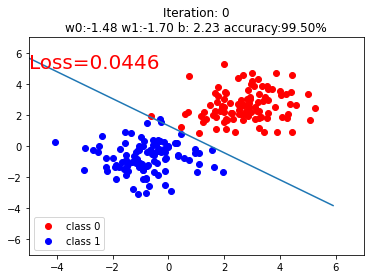

In [40]:
# Training
for iteration in range(1000):
    y_pred = lr_net(train_x)
    loss = loss_fn(y_pred.squeeze(), train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()  # remember to clear then grad

    if iteration % 60 == 0:
        mask = y_pred.ge(
            0.5).float().squeeze()  # Use 0.5 as a threshold for classification
        correct = (mask == train_y).sum()
        acc = correct.item() / train_y.size(0)

        plt.scatter(x0.data.numpy()[:, 0],
                    x0.data.numpy()[:, 1],
                    c='r',
                    label='class 0')
        plt.scatter(x1.data.numpy()[:, 0],
                    x1.data.numpy()[:, 1],
                    c='b',
                    label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5,
                 5,
                 'Loss=%.4f' % loss.data.numpy(),
                 fontdict={
                     'size': 20,
                     'color': 'red'
                 })
        plt.title(
            "Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".
            format(iteration, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.5)

        if acc > 0.99:
            break